## In this discussion, we will walk you through some basic preprocessing techniques that will help you achieve some performance boost.

## (i) Importing the necessary packages

In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, grad

import matplotlib.pyplot as plt

## (ii) Preprocessing the dataset and preparing the training, validation, and test datasets

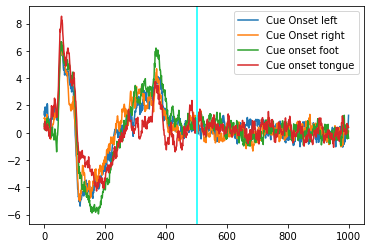

In [16]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [17]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [18]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
x_valid = torch.from_numpy(x_valid).type(torch.FloatTensor)
x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)
y_test = torch.from_numpy(y_test_prep)


#data loader
traindataset = torch.utils.data.TensorDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(dataset=traindataset, batch_size=64, shuffle=True, num_workers=1)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)


## (iii)(CNN) Defining the architecture of a basic CNN model

In [19]:
# # Building the CNN model using sequential class
class CNN(nn.Module):
    # initializers
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(22, 25, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool1 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(25)
        self.dropout = nn.Dropout2d(p=0.5)

        self.conv2 = nn.Conv2d(25, 50, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool2 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn2 = nn.BatchNorm2d(50)

        self.conv3 = nn.Conv2d(50, 100, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool3 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(0, 0))
        self.bn3 = nn.BatchNorm2d(100)

        self.conv4 = nn.Conv2d(100, 200, (10, 1), padding=(5, 0), stride=(1, 1))
        self.pool4 = nn.MaxPool2d((3, 1), stride=(3, 1),padding=(1, 0))
        self.bn4 = nn.BatchNorm2d(200)
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(800,4)
        

    # forward method
    def forward(self, input):  #input(22,250,1)
        x = self.dropout(self.bn1(self.pool1(F.elu(self.conv1(input)))))
        x = self.dropout(self.bn2(self.pool2(F.elu(self.conv2(x)))))
        x = self.dropout(self.bn3(self.pool3(F.elu(self.conv3(x)))))
        x = self.dropout(self.bn4(self.pool4(F.elu(self.conv4(x)))))
        x = self.flatten(x)
        out = self.dense(x) 
        return out


## (iv)(CNN) Defining the hyperparameters of the basic CNN model

In [20]:
# Model parameters
learning_rate = 1e-3
epochs = 50

## (v)(CNN) Compiling, training and validating the model

In [21]:
cnn = CNN()
cnn.cuda()
cnn_optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
cnn_loss = nn.CrossEntropyLoss().cuda()


train_accuracys = []
val_accuracys = []
train_losses = []
val_losses = []

for epoch in range(epochs):
    losses = []
    accuracys = []
    for x_, y_ in train_loader:
        x_, y_ = x_.cuda(), y_.cuda()
        cnn.zero_grad()
        out = cnn(x_)
        loss = cnn_loss(out, y_.long())
        loss.backward()
        cnn_optimizer.step()
        
        preds_ = out.data.max(1)[1]
        correct = preds_.eq(y_.data).cpu().sum()
        acc = float(correct) / float(len(y_.data)) * 100.0
        accuracys.append(acc)
        losses.append(loss.item())
    
    cnn.eval()
    x_valid,y_valid = x_valid.cuda(), y_valid.cuda()
    val = cnn(x_valid)
    val_loss = cnn_loss(val, y_valid.long())
    preds_ = val.data.max(1)[1]
    correct = preds_.eq(y_valid.data).cpu().sum()
    acc = float(correct) / float(len(y_valid.data)) * 100.0
    
    
    train_accuracy = torch.mean(torch.FloatTensor(accuracys))
    train_loss = torch.mean(torch.FloatTensor(losses))
    
    train_accuracys.append(train_accuracy.item())
    train_losses.append(train_loss.item())
    val_accuracys.append(acc)
    val_losses.append(val_loss.item())
    print('epoch: %d----loss: %.3f, accuracy: %.3f, val_loss: %.3f, val_acc: %.3f' % (epoch+1,train_loss,train_accuracy,val_loss,acc))
    cnn.train()


epoch: 1----loss: 1.490, accuracy: 33.104, val_loss: 1.219, val_acc: 44.467
epoch: 2----loss: 1.279, accuracy: 41.117, val_loss: 1.150, val_acc: 50.267
epoch: 3----loss: 1.194, accuracy: 47.444, val_loss: 1.060, val_acc: 55.333
epoch: 4----loss: 1.145, accuracy: 51.357, val_loss: 0.977, val_acc: 59.600
epoch: 5----loss: 1.105, accuracy: 53.340, val_loss: 0.958, val_acc: 60.333
epoch: 6----loss: 1.052, accuracy: 56.197, val_loss: 0.895, val_acc: 64.400
epoch: 7----loss: 1.014, accuracy: 58.180, val_loss: 0.835, val_acc: 67.267
epoch: 8----loss: 1.013, accuracy: 58.921, val_loss: 0.807, val_acc: 68.267
epoch: 9----loss: 0.971, accuracy: 60.641, val_loss: 0.778, val_acc: 69.000
epoch: 10----loss: 0.938, accuracy: 62.591, val_loss: 0.722, val_acc: 73.000
epoch: 11----loss: 0.900, accuracy: 63.857, val_loss: 0.698, val_acc: 72.733
epoch: 12----loss: 0.858, accuracy: 66.093, val_loss: 0.654, val_acc: 75.733
epoch: 13----loss: 0.845, accuracy: 66.151, val_loss: 0.606, val_acc: 77.200
epoch: 1

## (vi)(CNN) Visualizing the accuracy and loss trajectory

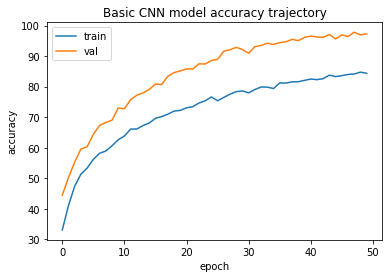

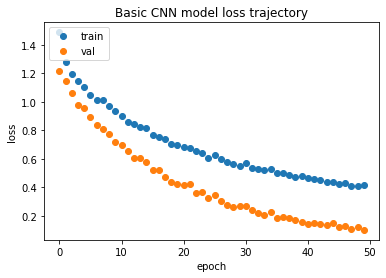

In [22]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(train_accuracys)
plt.plot(val_accuracys)
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(train_losses,'o')
plt.plot(val_losses,'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## (vii)(CNN) Testing the performance of the basic CNN model on the held out test set

In [23]:
## Testing the basic CNN model
cnn.eval()
x_test,y_test = x_test.cuda(), y_test.cuda()
test_pre = cnn(x_test)
test_pre = test_pre.data.max(1)[1]
correct = test_pre.eq(y_test.data).cpu().sum()
acc = float(correct) / float(len(y_test.data)) * 100.0

print('Test accuracy:',acc)

Test accuracy: 68.39729119638827
